# Ground Layer Adaptive Optics Reconstructor

In [1]:
import math
import numpy as np
import ceo
import yaml
import matplotlib.pyplot as plt
%matplotlib inline

GMT Atmosphere with strong turbulence near the ground

In [2]:
atm =  ceo.GmtAtmosphere(0.15,30,ID=2)

A V band on-axis source is defined first,

In [3]:
NL = 48
NA = NL+1
zen = np.ones(3)*6
azi = np.arange(3)*2*np.pi/3
ngs = ceo.Source('Vs',zenith=zen,azimuth=azi*ceo.constants.ARCMIN2RAD,resolution=(NA,NA))

The telescope pupil is defined as the Giant Magellan Telescope and mask for the deformable mirror actuators is also set.

In [4]:
D = 25.5
tel = ceo.GMT(NL*16,D)
dm  = ceo.Mask(NA,D)

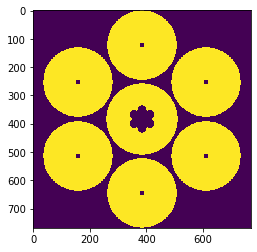

In [5]:
plt.imshow(tel.f.host(shape=(NL*16,NL*16)),interpolation='None')

A `Centroiding` object is defined, it will contains the phase screen gradient.
The `fried_geometry` method computes the DM valid actuator mask according to the telescope pupil shape and the given intensity `threshlod`.
The `Source` object is masked with the dm mask.

In [6]:
d = D/NL
cog = ceo.Centroiding(NL,ngs.N_SRC)
cog.fried_geometry(dm, tel, 16, 0.5)
ngs.masked(dm)

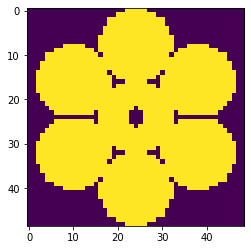

In [7]:
plt.imshow(dm.f.host(shape=(NA,NA)),interpolation='None')

Sampling a 10' diameter field of view:

In [14]:
data = np.loadtxt("KPP_field_sampler.csv",delimiter=',',skiprows=1)
zen_sc = data[:,0]
azi_sc = data[:,1]*np.pi/180

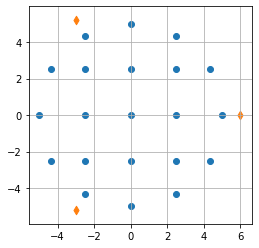

In [34]:
fig,ax = plt.subplots()
x_sc = zen_sc*np.cos(azi_sc)
y_sc = zen_sc*np.sin(azi_sc)
ax.scatter(x_sc,y_sc)
x = zen*np.cos(azi)
y = zen*np.sin(azi)
ax.scatter(x,y,marker='d')
ax.grid()
ax.set_aspect('equal')

In [16]:
src = ceo.Source('Vs',zenith=zen_sc*ceo.constants.ARCMIN2RAD,azimuth=azi_sc,resolution=(NA,NA))

In [17]:
dm_mask = dm.f
src.masked(dm)

In [18]:
p = D/(NA-1)
atm.get_phase_screen(src,p,NA,p,NA,0.0)
src_phase = src.phase.host(units='micron')#,zm=True,mask=dm_mask.host())

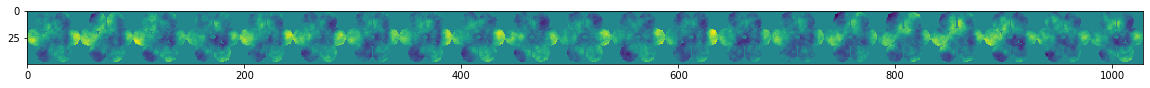

In [13]:
fig,ax=plt.subplots(figsize=(20,4))
ax.imshow(src_phase.T)

NGS slopes:

In [19]:
atm.get_phase_screen_gradient(cog,NL,d,ngs,0.0)
c = cog.c.host(units='arcsec')

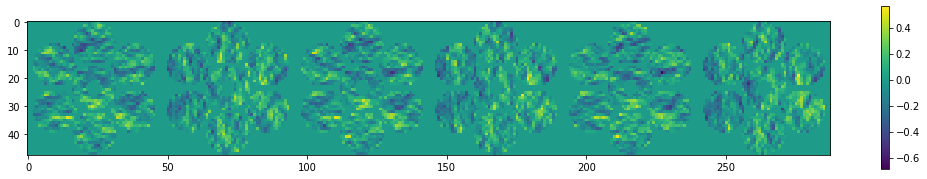

In [20]:
fig,ax = plt.subplots(figsize=(18,3))
h = ax.imshow(np.hstack(np.vsplit(c.reshape(NL*2*ngs.N_SRC,NL),ngs.N_SRC*2)))
fig.colorbar(h,ax=ax)

On axis wavefront:

In [24]:
src0 = ceo.Source('Vs',resolution=(NA,NA))
src0.masked(dm)
atm.get_phase_screen(src0,p,NA,p,NA,0.0)
src0_phase = src0.phase.host(units='micron',zm=True,mask=dm_mask.host())

In [25]:
print("Fitting error: {:.0f}nm".format(np.sqrt(0.335*(D/atm.r0)**(5/3)*(NA**2*np.pi/4)**(-5/6))*500/2/np.pi))

Fitting error: 144nm


GLAO wavefront estimation witin a 10' diameter fov:

In [26]:
palmmse = ceo.ALmmse(atm,ngs,ceo.constants.ARCMIN2RAD*5,d,NL,dm,"MINRES")
palmmse.estimation(cog)
palmmse_phase = palmmse.phase.host(units='micron',zm=True,mask=dm_mask.host())

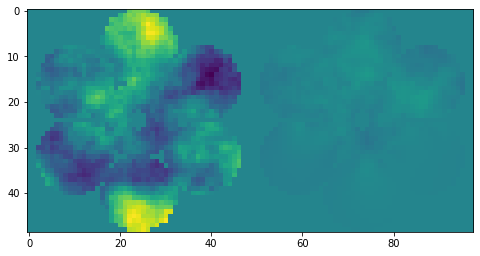

In [27]:
fig,ax = plt.subplots(figsize=(8,10))
h = ax.imshow(np.hstack([src0_phase,palmmse_phase]))

In [28]:
m = dm_mask.host().ravel()==1

In [41]:
wfe_rms = 1e3*src_phase.reshape(-1,NA*NA)[:,m].std(-1)

In [42]:
res_wfe_rms = 1e3*(src_phase.reshape(-1,49*49)-palmmse_phase.reshape(-1,NA*NA))[:,m].std(-1)

In [45]:
print("WFE RMS [nm]:")
print(" * before GLAO: {}".format(np.array_str(wfe_rms,precision=0)))
print(" * after GLAO: {}".format(np.array_str(res_wfe_rms,precision=0)))

WFE RMS [nm]:
 * before GLAO: [1742. 1910. 1788. 1567. 1802. 1803. 1659. 1834. 1785. 1776. 1592. 1704.
 1870. 1589. 1572. 1788. 1818. 1929. 2085. 1587. 1696.]
 * after GLAO: [1693. 1864. 1738. 1519. 1771. 1720. 1639. 1796. 1729. 1693. 1524. 1666.
 1865. 1560. 1541. 1757. 1795. 1897. 2009. 1540. 1647.]


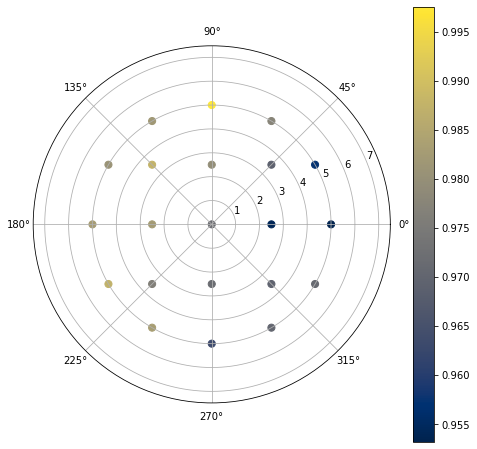

In [55]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='polar')
h = ax.scatter(azi_sc,zen_sc,c=res_wfe_rms/wfe_rms,s=50,cmap='cividis')
fig.colorbar(h,ax=ax)

In [73]:
n_sample = 100
wfe_var = []
res_wfe_var = []
for k in range(n_sample):
    print(f"\r{k}",end="")
    atm.reset()
    atm.get_phase_screen(src,p,NA,p,NA,0.0)
    src_phase = src.phase.host(units='micron')#,zm=True,mask=dm_mask.host())
    wfe_var += [src_phase.reshape(-1,NA*NA)[:,m].var(-1)]
    atm.get_phase_screen_gradient(cog,NL,d,ngs,0.0)
    palmmse.estimation(cog)
    palmmse_phase = palmmse.phase.host(units='micron',zm=True,mask=dm_mask.host())
    res_wfe_var += [(src_phase.reshape(-1,49*49)-palmmse_phase.reshape(-1,NA*NA))[:,m].var(-1)]

99

In [74]:
wfe_rms = 1e3*np.sqrt(np.vstack(wfe_var).mean(0))
res_wfe_rms = 1e3*np.sqrt(np.vstack(res_wfe_var).mean(0))

In [75]:
print("WFE RMS [nm]:")
print(" * before GLAO: {}".format(np.array_str(wfe_rms,precision=0)))
print(" * after GLAO: {}".format(np.array_str(res_wfe_rms,precision=0)))

WFE RMS [nm]:
 * before GLAO: [1723. 1667. 1692. 1712. 1694. 1731. 1709. 1737. 1728. 1715. 1707. 1702.
 1699. 1683. 1691. 1683. 1686. 1682. 1702. 1704. 1693.]
 * after GLAO: [1689. 1625. 1650. 1675. 1652. 1699. 1671. 1707. 1704. 1684. 1681. 1677.
 1669. 1650. 1653. 1635. 1646. 1640. 1665. 1664. 1658.]


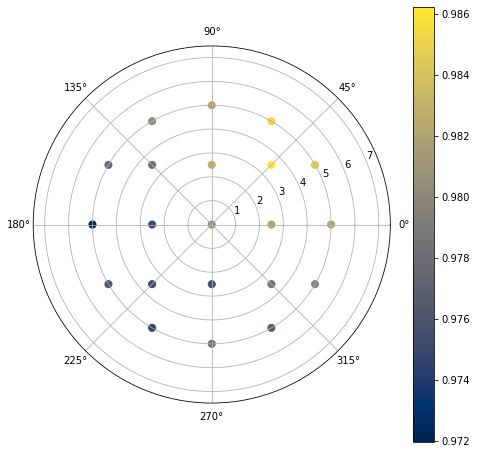

In [76]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='polar')
h = ax.scatter(azi_sc,zen_sc,c=res_wfe_rms/wfe_rms,s=50,cmap='cividis')
fig.colorbar(h,ax=ax)